# WGAN

## 1. Import libraries

In [91]:
import sys
import os
import random
import numpy as np
import datetime
import shutil
import logging

import torch
import torch.nn as nn
from torch import autograd
from tqdm.auto import tqdm
from torchvision import transforms
# from torchvision.datasets import MNIST
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
import torchvision.datasets as dset # all datasets available in torch vision. not sure if needed here
import torchvision.utils as vutils # draw bounding box, segmantation mask, keypoints. convert to rgb, make grid, save_image
import torch.optim as optim # optimizer for example optim.Adam([var1, var2], lr=0.0001)

import ignite
import ignite.distributed as idist
from ignite.metrics import FID, InceptionScore

import optuna
from optuna.trial import TrialState
import mlflow

# data distributed parallelization DDP
import torch.multiprocessing as mp
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group

import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for testing purposes, please do not change!
import matplotlib.animation as animation
from IPython.display import HTML # to embed html in the Ipython output

sys.path.append("../src/models/")
sys.path.append("../src/utils/")
from Generator import OptGen, OptGenGreyscale, OptGenGreyscale128
from Discriminator import OptDis, OptDis128
from utils import normalizeRGB
from utils import weights_init
from OptimisationFunctions import suggest_hyperparameters, trainModel, test, objective, gradient_penalty

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Set the parameters

In [92]:
dataroot = "../../png/train" # Root directory for train dataset
datarootTest = "../../png/test" # Root directory for dataset
cadastralRoot = '../../cadastralExportRGB' # Root directory for cadastral images
cadastralRootGreyscale = '../../cadastralExport' # Root directory for cadastral images in greyscale
workers = 2 # Number of workers for dataloader
batch_size = 64 # Batch size during training
image_size = 128 # Spatial size of training images. All images will be resized to this
nc = 3 # Number of channels in the training images. For color images this is 3
nz = 100 # Size of z latent vector (i.e. size of generator input)
ngf = 64 # Size of feature maps in generator
ndf = 64 # Size of feature maps in discriminator
num_epochs = 50 # Number of training epochs
lr = 0.0002 # Learning rate for optimizers
beta1 = 0.5 # Beta1 hyperparam for Adam optimizers
lambda_gradient_penality = 0.2 # to adjust the Wasserstein distance with interpolation between real and fake data
ngpu = torch.cuda.device_count() # Number of GPUs available. Use 0 for CPU mode.

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# logging
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
formatter = logging.Formatter("%(asctime)s:%(levelname)s:%(message)s")
file_handler = logging.FileHandler('../reports/07_WGAN.log')
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

## 2. Load Datasets

### 2.1 Satellite Images

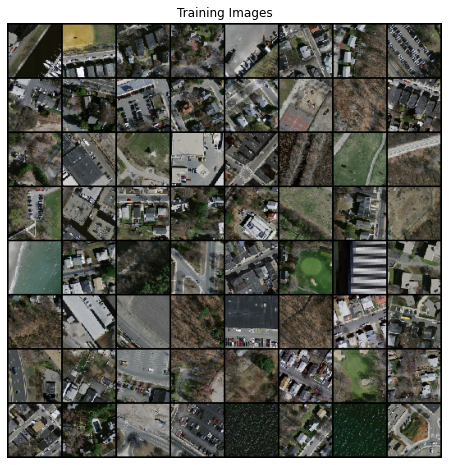

In [4]:
# We can use an image folder dataset the way we have it setup.
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               # transforms.Resize(image_size*4),
                               transforms.RandomCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)));

In [5]:
dataset

Dataset ImageFolder
    Number of datapoints: 103
    Root location: ../../png/train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(64, 64), padding=None)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

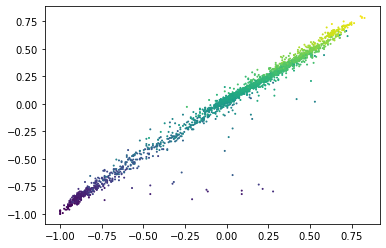

In [6]:
i = random.sample(range(batch_size), 1)[0]
plt.scatter(real_batch[0][i][0], real_batch[0][i][1], s = 1, c = real_batch[0][i][2]);

### 2.2 Cadastral Images as Probabilities

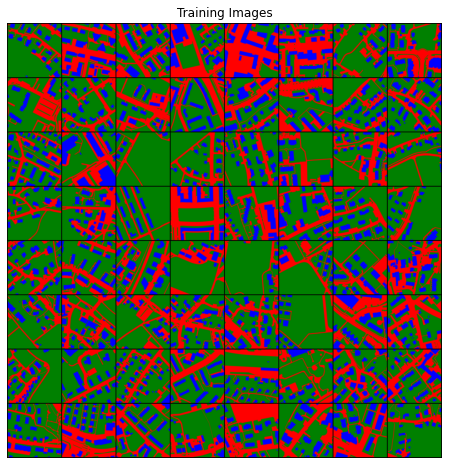

In [4]:
# We can use an image folder dataset the way we have it setup
if os.path.exists(cadastralRoot + '/.ipynb_checkpoints'):
    shutil.rmtree(cadastralRoot + '/.ipynb_checkpoints')

Cad_dataset = dset.ImageFolder(root=cadastralRoot,
                           transform=transforms.Compose([
                               transforms.RandomRotation(degrees=(0,180), expand = False),
                               transforms.CenterCrop(image_size * 5),
                               transforms.Resize(image_size),
                               # transforms.RandomCrop(image_size),
                               transforms.ToTensor(),
                               # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), -> 
                           ]))
# Create the dataloader
Cad_dataloader = torch.utils.data.DataLoader(Cad_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Plot some training images
Cad_real_batch = next(iter(Cad_dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(Cad_real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)));

In [5]:
Cad_dataset

Dataset ImageFolder
    Number of datapoints: 983
    Root location: ../../cadastralExportRGB
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[0.0, 180.0], interpolation=nearest, expand=False, fill=0)
               CenterCrop(size=(640, 640))
               Resize(size=128, interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )

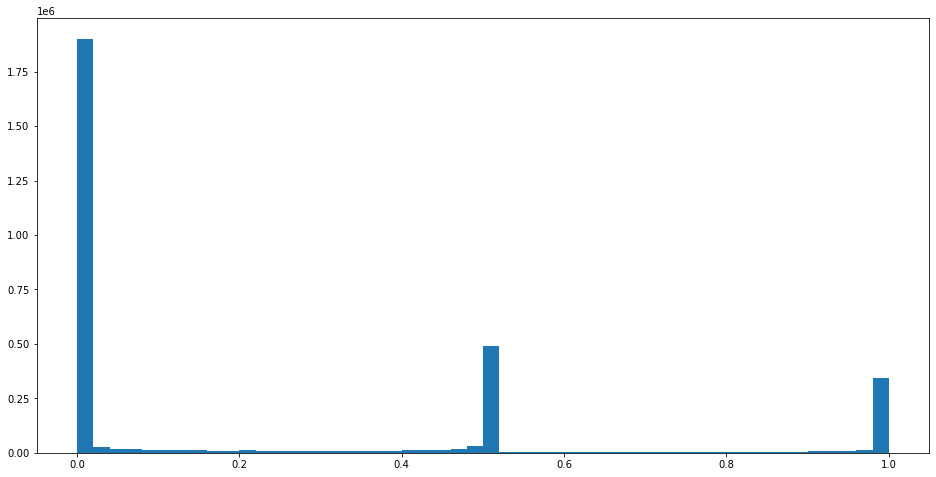

In [7]:
plt.figure(figsize=(16, 8))
plt.hist(Cad_real_batch[0].cpu().flatten().tolist(), bins = 50);

In [8]:
Cad_real_batch[0][0]

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.8824, 1.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.2784, 0.8784, 1.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.5020, 0.5020, 0.5020],
         [0.0000, 0.0000, 0.0000,  ..., 0.5020, 0.5020, 0.5020],
         [0.0000, 0.0000, 0.0000,  ..., 0.5020, 0.5020, 0.5020],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.5020, 0.5020, 0.5020],
         [0.0588, 0.0000, 0.0000,  ..., 0.5020, 0.5020, 0.5020],
         [0.3647, 0.0627, 0.0000,  ..., 0.5020, 0.5020, 0.5020]],

        [[1.0000, 1.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
         [1.0000, 1.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
         [1.0000, 1.0000, 1.0000,  ..., 0.0000, 0.0000, 0.

In [9]:
Cad_real_batch[0][0].sum(0)

tensor([[1.0000, 1.0000, 1.0000,  ..., 0.5020, 0.5020, 0.5020],
        [1.0000, 1.0000, 1.0000,  ..., 0.5020, 0.5020, 0.5020],
        [1.0000, 1.0000, 1.0000,  ..., 0.5020, 0.5020, 0.5020],
        ...,
        [1.0000, 1.0000, 1.0000,  ..., 0.5020, 0.5020, 0.5020],
        [0.9412, 1.0000, 1.0000,  ..., 0.5020, 0.5020, 0.5020],
        [0.6431, 0.9412, 1.0000,  ..., 0.5020, 0.5020, 0.5020]])

### 2.3 Cadastral Dataset Greyscale 128 x 128 px

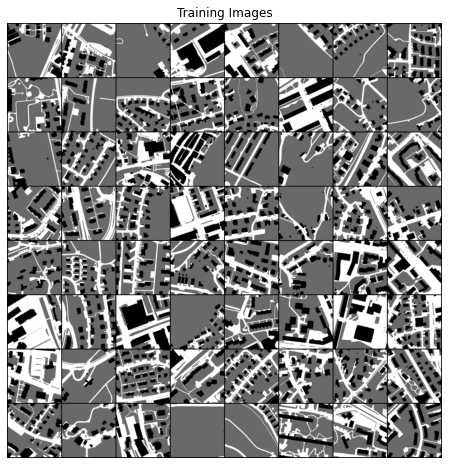

In [93]:
# We can use an image folder dataset the way we have it setup
if os.path.exists(cadastralRootGreyscale + '/.ipynb_checkpoints'):
    shutil.rmtree(cadastralRootGreyscale + '/.ipynb_checkpoints')

Cad_dataset_greyscale = dset.ImageFolder(root=cadastralRootGreyscale,
                           transform=transforms.Compose([
                               transforms.RandomRotation(degrees=(0,180), expand = False),
                               transforms.CenterCrop(image_size * 5),
                               transforms.Resize(image_size),
                               # transforms.RandomCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
Cad_dataloader_greyscale = torch.utils.data.DataLoader(Cad_dataset_greyscale, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Plot some training images
Cad_gs_real_batch = next(iter(Cad_dataloader_greyscale))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(Cad_gs_real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)));

In [94]:
Cad_dataset_greyscale

Dataset ImageFolder
    Number of datapoints: 2569
    Root location: ../../cadastralExport
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[0.0, 180.0], interpolation=nearest, expand=False, fill=0)
               CenterCrop(size=(640, 640))
               Resize(size=128, interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

### 2.4 Cadastral Dataset Greyscale 64 x 64 px

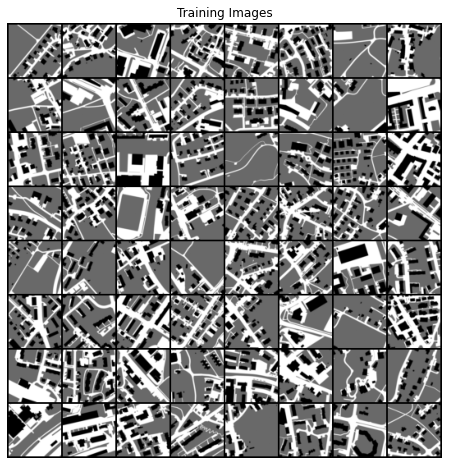

In [49]:
# We can use an image folder dataset the way we have it setup
if os.path.exists(cadastralRootGreyscale + '/.ipynb_checkpoints'):
    shutil.rmtree(cadastralRootGreyscale + '/.ipynb_checkpoints')

Cad_dataset_greyscale64 = dset.ImageFolder(root=cadastralRootGreyscale,
                           transform=transforms.Compose([
                               transforms.RandomRotation(degrees=(0,180), expand = False),
                               transforms.CenterCrop(image_size * 5),
                               transforms.Resize(int(image_size / 2)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
Cad_dataloader_greyscale64 = torch.utils.data.DataLoader(Cad_dataset_greyscale64, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Plot some training images
Cad_gs_real_batch64 = next(iter(Cad_dataloader_greyscale64))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(Cad_gs_real_batch64[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)));

## 3. Import Generator

### 3.1 Generator for images with 64 pixels

In [88]:
netG = OptGen(ngpu=ngpu, num_conv_layers=4, drop_conv2=0.4).to(device)
netG.apply(weights_init)
print(netG)

IndexError: list index out of range

In [12]:
%%time
z = torch.randn(64, nz, 1, 1, device=device)
pred = netG.forward(z)

CPU times: user 1.25 s, sys: 946 ms, total: 2.19 s
Wall time: 5.69 s


In [18]:
netGGS128 = OptGenGreyscale128(ngpu=ngpu, num_conv_layers=4, drop_conv2=0.4).to(device)
netGGS128.apply(weights_init)
print(netGGS128)

OptGenGreyscale128(
  (main): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(2, 2), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): TransConv_2): ConvTranspose2d(256, 128, kernel_size=(9, 9), stride=(1, 1), bias=False)
    (4): DropOut_2): Dropout2d(p=0.4, inplace=False)
    (5): BatchNorm_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU_2): ReLU(inplace=True)
    (7): TransConv_3): ConvTranspose2d(128, 64, kernel_size=(9, 9), stride=(1, 1), bias=False)
    (8): DropOut_3): Dropout2d(p=0.4, inplace=False)
    (9): BatchNorm_3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU_3): ReLU(inplace=True)
    (11): TransConv_4): ConvTranspose2d(64, 3, kernel_size=(9, 9), stride=(7, 7), bias=False)
    (12): Tanh()
  )
)


In [21]:
%%time
z = torch.randn(batch_size, nz, 1, 1, device=device)
pred = netGGS128.forward(z)

CPU times: user 1.7 ms, sys: 529 µs, total: 2.23 ms
Wall time: 1.65 ms


### 3.2 Trying the old gen class
not needed, since the problem was elsewhere..

In [258]:
## class Generator(nn.Module):
##     def __init__(self, ngpu):
##         super(Generator, self).__init__()
##         self.ngpu = ngpu
##         self.main = nn.Sequential(
##             # input is Z, going into a convolution with dimensions c=nz, h=1, w=1
##             nn.ConvTranspose2d(in_channels=nz, #deconvolution!
##                                out_channels=ngf * 8, 
##                                kernel_size=4, 
##                                stride=1, 
##                                padding=0, 
##                                bias=False), #no learnable bias 
##             nn.BatchNorm2d(ngf * 8),
##             nn.ReLU(True),
##             # state size. (ngf*8) x 4 x 4
##             nn.ConvTranspose2d(in_channels=ngf * 8, 
##                                out_channels=ngf * 4, 
##                                kernel_size=4, 
##                                stride=2, 
##                                padding=1, 
##                                bias=False),
##             nn.BatchNorm2d(ngf * 4), # accelerates the learning rate by 14 times
##             nn.ReLU(True),
##             # state size. (ngf*4) x 8 x 8
##             nn.ConvTranspose2d(in_channels=ngf * 4, 
##                                out_channels=ngf * 2, 
##                                kernel_size=4, 
##                                stride=2, 
##                                padding=1, 
##                                bias=False),
##             nn.BatchNorm2d(ngf * 2),
##             nn.ReLU(True),
##             # state size. (ngf*2) x 16 x 16
##             nn.ConvTranspose2d(in_channels=ngf * 2, 
##                                out_channels=ngf, 
##                                kernel_size=4, 
##                                stride=2, 
##                                padding=1, 
##                                bias=False),
##             nn.BatchNorm2d(ngf),
##             nn.ReLU(True),
##             # state size. (ngf) x 32 x 32
##             nn.ConvTranspose2d(in_channels=ngf, 
##                                out_channels=nc, 
##                                kernel_size=4, 
##                                stride=2, 
##                                padding=1, 
##                                bias=False),
##             nn.Tanh() # since the desired output is in range of -1 and +1 (impossible with ReLU and sigmoid D[0,1])
##             # state size. (nc) x 64 x 64
##         )
## 
##     def forward(self, input):
##         return self.main(input)

In [259]:
## # Create the generator
## netG = Generator(ngpu).to(device)
## 
## # Handle multi-gpu if desired
## if (device.type == 'cuda') and (ngpu > 1):
##     netG = nn.DataParallel(module=netG, devide_ids=list(range(ngpu))) # recommended to use DistributedDataParallel instead
## 
## # Apply the weights_init function to randomly initialize all weights
## #  to mean=0, stdev=0.02.
## netG.apply(weights_init)
## 
## # Print the model
## print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


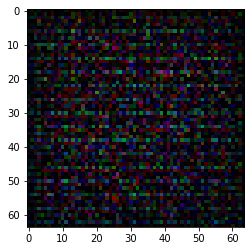

In [260]:
## noise = torch.randn(64, nz, 1, 1, device=device)
## plt.imshow(netG(noise).detach().cpu()[0].permute(1,2,0));

### 3.3 Generator Greyscale 128 x 128 pixels 

In [97]:
netG128 = OptGenGreyscale128(ngpu=ngpu, num_conv_layers=4, drop_conv2=0.2).to(device)
print(netG128)

OptGenGreyscale128(
  (main): Sequential(
    (0): ConvTranspose2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): TransConv_2): ConvTranspose2d(16, 64, kernel_size=(5, 5), stride=(3, 3), bias=False)
    (4): DropOut_2): Dropout2d(p=0.2, inplace=False)
    (5): BatchNorm_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU_2): ReLU(inplace=True)
    (7): TransConv_3): ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1), bias=False)
    (8): DropOut_3): Dropout2d(p=0.2, inplace=False)
    (9): BatchNorm_3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU_3): ReLU(inplace=True)
    (11): TransConv_4): ConvTranspose2d(32, 3, kernel_size=(7, 7), stride=(3, 3), padding=(1, 1), bias=False)
    (12): Tanh()
  )
)


In [100]:
x = torch.rand((64*2**4*4*4)).to(device)
x = x.flatten()
netG128(x).size()

torch.Size([64, 3, 128, 128])


## 4. Import Discriminator

In [52]:
netD = OptDis(ngpu=ngpu, num_conv_layers=3).to(device)
netD.apply(weights_init)
print(netD)

OptDis(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(3, 3), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv_2): Conv2d(64, 128, kernel_size=(5, 5), stride=(3, 3), bias=False)
    (3): BatchNorm_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU_2): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv_3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (Flatten): Flatten(start_dim=1, end_dim=-1)
    (Fully Connected): Linear(in_features=9216, out_features=1, bias=True)
  )
)


In [55]:
netD(Cad_gs_real_batch64[0].to(device)).size()

torch.Size([64, 1])

### 4.1 Discriminator with 128 x 128 px

In [95]:
netD128 = OptDis128(ngpu=ngpu, num_conv_layers=3).to(device)
netD128.apply(weights_init)
print(netD128)

OptDis128(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(3, 3), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv_2): Conv2d(64, 128, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1), bias=False)
    (3): BatchNorm_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU_2): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv_3): Conv2d(128, 256, kernel_size=(5, 5), stride=(3, 3), bias=False)
    (Flatten): Flatten(start_dim=1, end_dim=-1)
    (Fully Connected): Linear(in_features=4096, out_features=1, bias=True)
  )
)


In [96]:
%%time
xr = Cad_gs_real_batch[0].to(device)
netD128(xr).view(-1).size()

CPU times: user 5.82 ms, sys: 565 µs, total: 6.39 ms
Wall time: 5.77 ms


torch.Size([64])

# 5. Train Models

In [32]:
# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999)) # lr can be a param
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999)) # lr can be a param

# lists for reporting
img_list = []
G_losses = []
D_losses = []

# seeds for torch and numpy
torch.manual_seed(23)
np.random.seed(23)

NameError: name 'netD' is not defined

### 5.1 Introducing gradient penalty
GP stabilizes the training whe using Wasserstein distance. It adds a new term in the loss function that represents the interpolation between real and fake distributions weighted by a factor $\lambda$.
The gradient penalty is:
$\hat{x}=t*x_{real}+(1-t)x_{fake}$ with $0\leq t \leq 1$

The loss function including gradient penality is:</br>
$L=E_{\tilde{x} \sim P_g}[D(\tilde{x})]-E_{x \sim P_r}[D(x)]+\lambda E_{\hat{x} \sim P_{\hat{x}}}[(||\nabla_{\hat{x}}D(\hat{x})||_2-1)^2]$

In [15]:
def gradient_penalty(D, xr, xf):
    """
    :param D:
    :param xr: [b, 2]
    :param xf: [b, 2]
    :return:
    """
    # [b, 1]
    t = torch.rand(batch_size, 1).cuda()
    # [b, 1] => [b, 2]  broadcasting so t is the same for x1 and x2
    t = t.expand_as(xr)
    # interpolation
    mid = t * xr + (1 - t) * xf
    # set it to require grad info
    mid.requires_grad_()
    
    pred = D(mid)
    grads = autograd.grad(outputs=pred, inputs=mid,
                          grad_outputs=torch.ones_like(pred),
                          create_graph=True, retain_graph=True, only_inputs=True)[0]

    gp = torch.pow(grads.norm(2, dim=1) - 1, 2).mean()

    return gp

### 5.2 Other penalty
no other penalty need to be introduced, since the optimisation is enough to have GNet values converge to 0 or 1

In [94]:
# def probability_penalty(batch_probs: torch.tensor):
#     '''
#     this function returns a penalty if the none of the value in the tensor is close to 1.
#     the idea is to push the generator to assign 1 to one of the values
#     '''
#     penalty =  1 - batch_probs.max(dim=3).values.mean()
#     return penalty

### 5.3 Train Model
The training is based on the function trainModel saved under utils/OptimisationFunction.py
<p>
    Here the function is unpacked in order to debug
    </p>

In [24]:
# netG: Generator.OptGen
# netD: Discriminator
# device: cuda, cpu, ...
dataloader = Cad_dataloader # : dataloader to feed the learning process
# optimizerG: optimizer for the netG
# optimizerD: optimizer for the netD
epochs = num_epochs # : number of epochs to train the model
# nz: dimension of the noise tensor
# fixed_noise: tensor with fixed noise to evaluate the progress of the ge
folder = '../' # : path where to save the produced pictures and the log
experiment = '07_WGANRGB'#: prefix for the pictures
AlternativeTraining = 0 #: number of epochs in which netG and netD are traine If 0, then both netD and netG are trained at the same time
# logger: logger to save the logging

In [28]:
## def trainModel(netG, netD, device: torch.device, dataloader: torch.utils.data.dataloader.DataLoader, 
##                optimizerG, optimizerD, 
##                fixed_noise:torch.Tensor, folder: str, epochs: int = 10, nz: int = 100, 
##                experiment: str = 'WGANRGB',
##                AlternativeTraining: int = 0, logger: logging.Logger = None):
'''
Params:
    netG: Generator.OptGen
    netD: Discriminator
    device: cuda, cpu, ...
    dataloader: dataloader to feed the learning process
    optimizerG: optimizer for the netG
    optimizerD: optimizer for the netD
    epochs: number of epochs to train the model
    nz: dimension of the noise tensor
    fixed_noise: tensor with fixed noise to evaluate the progress of the generator
    folder: path where to save the produced pictures and the log
    experiment: prefix for the pictures
    AlternativeTraining: number of epochs in which netG and netD are trained exclusively. 
        If 0, then both netD and netG are trained at the same time
    logger: logger to save the logging

    Returns the pictures generated by netG after n steps and optimizes both the parameters
    of netG and netD by training them using the Wasserstein distance and the gradient penalty

'''

img_list = []
isDLearning = False
if logger:
    logger.debug(f'Training GANS with NetG[conv. layers: {netG.num_conv_layers}, drop out: {netG.drop_conv2}] and NetD[conv. layers: {netD.num_conv_layers}]')
for epoch in range(epochs):
    # switch between training G and D
    if isDLearning and AlternativeTraining > 0:
        if ((epoch + 1) % AlternativeTraining) == 0:
            isDLearning = False
    elif AlternativeTraining > 0:
        if ((epoch + 1) % AlternativeTraining) == 0:
            isDLearning = True
    else:
        isDLearning = True
    for i, data in enumerate(dataloader, 0):
        xr = data[0].to(device)
        b_size = xr.size(0)
        z = torch.randn(b_size, nz, 1, 1).to(device)
        # 0 Set all gradients for D to 0
        netD.zero_grad()
        # 1.1 train on real data
        predr = netD(xr).view(-1)
        # maximize predr, therefore minus sign
        lossr = -predr.mean() # to be minimized in the optimization, therefore -inf is the goal
        # 1.2 train on fake data
        xf = netG(z).detach()  # without .detach() gradient would be passed down
        predf = netD(xf)
        # minimize predf
        lossf = predf.mean()
        # 1.3 gradient penalty
        gp = 0.2 * gradient_penalty(netD, xr, xf) # lambda gradient penalty = 0.2
        # aggregate all
        loss_D = lossr + lossf + gp 
        if isDLearning or AlternativeTraining == 0 or epoch == 0:
            loss_D.backward()
            optimizerD.step()
        # 2. train G
        netG.zero_grad()
        xf = netG(z)
        predf = netD(xf)
        # maximize predf.mean()
        loss_G = -predf.mean() # to be minimized in the optimization, therefore -1 is the goal
        if not isDLearning or AlternativeTraining == 0:
            loss_G.backward()
            optimizerG.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}/{epochs} | D Learn: {isDLearning} | D Loss: {np.round(loss_D.item(), 4)}' + 
              f'| ErrDReal: {np.round(lossr.item(), 4)} | ErrDFake: {np.round(lossf.item(), 4)} ' + 
              f'| GradPenality: {np.round(gp.item(), 4)} | G Loss: {np.round(loss_G.item(), 4)}')
    if epoch % 10 == 0:
        # Generate and save fake images to monitor the progress
        with torch.no_grad():
            fake = netG(fixed_noise).detach().cpu()
            i = random.sample(range(b_size), 1)[0]
            if epoch < 10:
                epoch = '000' + str(epoch)
            elif epoch < 100:
                epoch = '00' + str(epoch)
            elif epoch < 1000:
                epoch = '0' + str(epoch)
            path = folder + 'reports/WGANBestImages/' + experiment +'_Epoch_' + str(epoch) + '.png'
            fake_grid = vutils.make_grid(fake, padding=2, normalize=True)
            save_image(fake_grid, path) # save_image(fake[i], path)
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            if logger:
                logger.debug(f'Epoch: {epoch} | Error G: {loss_G} | Error D: {loss_D}')
# return (img_list)

Epoch: 0/50 | D Learn: True | D Loss: -25.013| ErrDReal: 1.1789 | ErrDFake: -26.3667 | GradPenality: 0.1747 | G Loss: 28.9671
Epoch: 10/50 | D Learn: True | D Loss: -142.8396| ErrDReal: -26.2047 | ErrDFake: -116.749 | GradPenality: 0.1141 | G Loss: 123.4827
Epoch: 20/50 | D Learn: True | D Loss: -252.4718| ErrDReal: -73.3314 | ErrDFake: -179.2226 | GradPenality: 0.0822 | G Loss: 214.0841
Epoch: 30/50 | D Learn: True | D Loss: -516.5564| ErrDReal: -145.0587 | ErrDFake: -371.5894 | GradPenality: 0.0917 | G Loss: 373.0928
Epoch: 40/50 | D Learn: True | D Loss: -736.2878| ErrDReal: -213.0689 | ErrDFake: -523.3962 | GradPenality: 0.1773 | G Loss: 528.3248


In [106]:
# Approch 1: first train G, then train both together -> failed, since once D starts learning it gets too good to recognize
# fake images
exclusive_G_Train = 0

# Approach 2: 
# G stops learning after few epochs, because D is too good in understanding if images are fake
# Idea: if the G loss in the n last epochs doesn't pass a certain score, then D stops learning and only G does
GLearningScore = [10]
history = 10 # epochs considered in for the GLearningScore and epochs before D starts the training
LearningThreshold = history / 2.0 # where 2.0 is arbitrary. The maximal absolute error each epoch is 1
# -> Could this parameter LearningThreshold be leaned with Optuna?
isDLearning = False

# Enable or disable alternative learning for D
alternative_learning = False

# Approach 3: Alternatively train D and G a certain number of epochs
switch = 50 # int(num_epochs / 10)

for epoch in range(num_epochs):
    # switch between training G and D
    if isDLearning:
        if ((epoch + 1) % switch) == 0:
            isDLearning = False
    else:
        if ((epoch + 1) % switch) == 0:
            isDLearning = True
    for i, data in enumerate(Cad_dataloader, 0):
        # first train G n epochs
        xr = data[0].to(device)
        b_size = xr.size(0)
        z = torch.randn(b_size, nz, 1, 1).to(device)
        # 0 Set all gradients for D to 0
        netD.zero_grad()
        # 1.1 train on real data
        predr = netD(xr).view(-1)
        # maximize predr, therefore minus sign
        lossr = -predr.mean() # to be minimized in the optimization, therefore -inf is the goal
        # 1.2 train on fake data
        xf = netG(z).detach()  # without .detach() gradient would be passed down
        predf = netD(xf)
        # minimize predf
        lossf = predf.mean()
        # 1.3 gradient penalty
        gp = lambda_gradient_penality * gradient_penalty(netD, xr, xf)
        # aggregate all
        loss_D = lossr + lossf + gp # lambda_gradient_penality * gp 
        # optimize Approach 2
        # if alternative_learning:
        #     if epoch > history and GLearningScore[-1] > LearningThreshold:
        #         isDLearning = True
        #         loss_D.backward()
        #         optimizerD.step()
        #     else:
        #         isDLearning = False
        # else: 
        #     isDLearning = True
        #     loss_D.backward()
        #     optimizerD.step()
        # optimize Approach 3
        if isDLearning or not alternative_learning:
            loss_D.backward()
            optimizerD.step()
        # 2. train G
        netG.zero_grad()
        xf = netG(z)
        predf = netD(xf)
        # maximize predf.mean()
        loss_G = -predf.mean() # to be minimized in the optimization, therefore -1 is the goal
        # optimize Approach 3
        if not isDLearning or not alternative_learning:
            loss_G.backward()
            optimizerG.step()
        # Save Losses for plotting later
        G_losses.append(loss_G.item())
        D_losses.append(loss_D.item())
    # update GLearningScore
    if epoch > history:
        GLearningScore.append(np.abs(np.sum(G_losses[-history:])))
    else:
        GLearningScore.append(GLearningScore[-1])
    if epoch % 1 == 0:
        # viz.line([[loss_D.item(), loss_G.item()]], [epoch], win='loss', update='append')
        print(f'Epoch: {epoch}/{num_epochs} DLearn: {isDLearning or not alternative_learning} | D Loss: {np.round(loss_D.item(), 4)}' + 
              f'| ErrDReal: {np.round(lossr.item(), 4)} | ErrDFake: {np.round(lossf.item(), 4)} ' + 
              f'| GradPenality: {np.round(gp.item(), 4)} | G Loss: {np.round(loss_G.item(), 4)}')
        with torch.no_grad():
            fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
        # generate_image(netD, netG, xr.cpu().numpy(), epoch)

Epoch: 0/500 DLearn: True | D Loss: -23.9707| ErrDReal: -8.4375 | ErrDFake: -15.7164 | GradPenality: 0.1832 | G Loss: 17.9255
Epoch: 1/500 DLearn: True | D Loss: -60.3089| ErrDReal: -27.7679 | ErrDFake: -32.7206 | GradPenality: 0.1796 | G Loss: 34.9781
Epoch: 2/500 DLearn: True | D Loss: -94.9998| ErrDReal: -46.2997 | ErrDFake: -48.875 | GradPenality: 0.175 | G Loss: 50.4734
Epoch: 3/500 DLearn: True | D Loss: -124.6933| ErrDReal: -62.567 | ErrDFake: -62.2967 | GradPenality: 0.1704 | G Loss: 63.7945
Epoch: 4/500 DLearn: True | D Loss: -153.2654| ErrDReal: -77.2475 | ErrDFake: -76.1831 | GradPenality: 0.1651 | G Loss: 77.5131
Epoch: 5/500 DLearn: True | D Loss: -178.6502| ErrDReal: -91.3999 | ErrDFake: -87.4096 | GradPenality: 0.1593 | G Loss: 88.711
Epoch: 6/500 DLearn: True | D Loss: -208.1686| ErrDReal: -105.7829 | ErrDFake: -102.5398 | GradPenality: 0.154 | G Loss: 103.8345
Epoch: 7/500 DLearn: True | D Loss: -234.2945| ErrDReal: -120.1436 | ErrDFake: -114.2998 | GradPenality: 0.148

KeyboardInterrupt: 

In [ ]:
plt.plot(GLearningScore);

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

In [ ]:
torch.save(netG, "../models/07NotebookWGANGenerator")
torch.save(netD, "../models/07NotebookWGANDiscriminator")

In [ ]:
i = random.sample(range(b_size), 1)[0]
plt.imshow(normalizeRGB(netG(fixed_noise)[i]).detach().cpu().permute(1,2,0));

In [ ]:
plt.imshow(np.transpose(vutils.make_grid(netG(fixed_noise).to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)));

In [ ]:
i = random.sample(range(b_size), 1)[0]
fig = plt.figure(figsize=(16,8))
plt.scatter(real_batch[0][i][0], real_batch[0][i][1], s = 1, label = 'real')
plt.scatter(netG(fixed_noise)[i].detach().cpu()[0], netG(fixed_noise)[i].detach().cpu()[1], s= 1, c = 'r', label = 'fake')
plt.title("Distribution of real and fake images over 2 RGB channels")
plt.legend();

### 5.4 Train Function
to optimise training -> functions are found in utils OptimisationFunctions.py

In [ ]:
# def trainModel(netG, netD, device, dataloader, optimizerG, optimizerD, epochs):
#     for epoch in range(epochs):
#         for i, data in enumerate(dataloader, 0):
#             xr = data[0].to(device)
#             b_size = xr.size(0)
#             z = torch.randn(b_size, nz, 1, 1).to(device)
#             # 0 Set all gradients for D to 0
#             netD.zero_grad()
#             # 1.1 train on real data
#             predr = netD(xr) #.view(-1)
#             # maximize predr, therefore minus sign
#             lossr = -predr.mean() # to be minimized in the optimization, therefore -1 is the goal
#             # 1.2 train on fake data
#             xf = netG(z)
#             predf = netD(xf.detach()).view(-1) # without .detach() gradient would be passed down
#             # minimize predf
#             lossf = predf.mean()
#             # 1.3 gradient penalty
#             gp = lambda_gradient_penality * gradient_penalty(netD, xr, xf.detach())
#             # aggregate all
#             loss_D = lossr + lossf + lambda_gradient_penality * gp
#             # optimize D
#             loss_D.backward()
#             optimizerD.step()
#             # 2. train G
#             netG.zero_grad()
#             predf = netD(xf).view(-1)
#             # maximize predf.mean()
#             loss_G = -predf.mean() # to be minimized in the optimization, therefore -1 is the goal
#             # optimize G
#             loss_G.backward()
#             optimizerG.step()
#             # Save Losses for plotting later
#             G_losses.append(loss_G.item())
#             D_losses.append(loss_D.item())
#         if epoch % 1 == 0:
#             print(f'Epoch: {epoch}/{epochs} | D Loss: {np.round(loss_D.item(), 4)}' + 
#                   f'| ErrDReal: {np.round(lossr.item(), 4)} | ErrDFake: {np.round(lossf.item(), 4)} ' + 
#                   f'| GradPenality: {np.round(gp.item(), 4)} | G Loss: {np.round(loss_G.item(), 4)}')
#             with torch.no_grad():
#                 fake = netG(fixed_noise).detach().cpu()
#                 img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

In [ ]:
# def test(netG, device, dataloader):
#     nz_dim = nz
#     errG = []
#     for i, data in enumerate(dataloader, 0):
#         real = data[0].to(device)
#         # batch_size, seq_len = real.size(0), real.size(1)
#         batch_size = real.size(0)
#         noise = torch.randn(batch_size, nz, 1, 1, device=device)
#         mse = nn.MSELoss()
#         with torch.no_grad():
#             fake = netG(noise)
#             ####
#             print(f"dimensions for the fake tensor: {fake.shape}")
#             errG += [mse(fake, real)]
#     v = torch.tensor(errG).float().mean().item()
#     print(f"mse_errG: {v}")
#     return v

In [ ]:
# def suggest_hyperparameters(trial):
#     lr = trial.suggest_float("lr", 1e-4, 1e-1, log=True)
#     dropoutG = trial.suggest_float("dropoutG", 0.0, 0.4, step=0.1)
#     # dropoutD = trial.suggest_float("dropoutD", 0.0, 0.4, step=0.1)
#     # optimizer_name = trial.suggest_categorical("optimizer_name", ["dropoutG", "Adadelta"])
#     convsG = trial.suggest_int("convsG", 3, 4, step=1)
#     convsD = trial.suggest_int("convsD", 3, 4, step=1)
#     return lr, convsG, convsD, dropoutG  #lr, optimizer_name, , dropoutD

In [ ]:
# def objective(trial: optuna.Trial):
#     best_val_loss = float('Inf')
#     nz_dim = nz
#     best_mse_val = None
# 
#     with mlflow.start_run():
# 
#         lr, convsG, convsD, dropoutG = suggest_hyperparameters(trial) # dropoutD, 
#         n_epochs = 10 #1000
#         torch.manual_seed(123)
#         mlflow.log_params(trial.params)
# 
#         device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#         mlflow.log_param("device", device)
#         
#         netD = OptDis(ngpu, convsD).to(device)
#         netG = OptGen(ngpu=ngpu, num_conv_layers=convsG, drop_conv2=dropoutG).to(device)
#         
#         optimizerD = getattr(optim, "Adam")(netD.parameters(), lr=lr)
#         optimizerG = getattr(optim, "Adam")(netG.parameters(), lr=lr)
#         
#         ###########
#         print(f"Convolutions for D: {convsD} | Convolutions for G: {convsG} | LrRate: {np.round(lr,4)} | Dropout G: {dropoutG}")
#         ##########
#         
#         trainModel(netG, netD, device, dataloader, optimizerG, optimizerD, n_epochs)
#         ##########
#         ## print(netG)
#         ## print(device)
#         ## print(dataloaderTest)
#         mse_errG = test(netG, device, dataloader)
#         
#         if best_mse_val is None:
#             best_mse_val = mse_errG
#             torch.save(netG, "../models/WGANGenerator")
#             torch.save(netD, "../models/WGANDiscriminator")
#         best_mse_val = min(best_mse_val, mse_errG)
#         mlflow.log_metric("mse_errG", mse_errG)
# 
#     return best_mse_val

In [ ]:
# run_tag = datetime.datetime.now().strftime("%Y-%m-%dT%H:%M")
# 
# experiment_id = mlflow.create_experiment(
#     f"../reports/TSGAN_Exp_{run_tag}",
#     tags={"version": "v1", "priority": "P1"},
# )
# 
# mlflow.set_experiment(experiment_id=experiment_id)
# study = optuna.create_study(study_name=f"WGAN_study_{run_tag}", direction="minimize")
# study.optimize(objective, n_trials=5)

### 5.5 Loading Train functions from WGANSatellite

In [7]:
%%time
run_tag = datetime.datetime.now().strftime("%Y-%m-%dT%H:%M:%S")

experiment_id = mlflow.create_experiment(
    f"../reports/TSGAN_Exp_{run_tag}",
    tags={"version": "v1", "priority": "P1"},
)

mlflow.set_experiment(experiment_id=experiment_id)
study = optuna.create_study(study_name=f"WGAN_study_{run_tag}", direction="minimize")

# Wrap the objective inside a lambda and call objective inside it
func = lambda trial: objective(trial, nz, dataloader, n_epochs = 50, folder = '../')

study.optimize(func, n_trials=1)

[I 2023-05-19 13:44:55,957] A new study created in memory with name: WGAN_study_2023-05-19T13:44:55


Convolutions for D: 3 | Convolutions for G: 6 | LrRate: 0.0296 | Dropout G: 0.4
Epoch: 0/50 | D Loss: -13.2402| ErrDReal: 0.0487 | ErrDFake: -13.4742 | GradPenality: 0.1853 | G Loss: 164.9107
Epoch: 10/50 | D Loss: -10721.5459| ErrDReal: -4018.5544 | ErrDFake: -6734.7812 | GradPenality: 31.7897 | G Loss: 7376.1646
Epoch: 20/50 | D Loss: -39148.5156| ErrDReal: -14702.3477 | ErrDFake: -24813.4688 | GradPenality: 367.3005 | G Loss: 26268.5234
Epoch: 30/50 | D Loss: -91413.3984| ErrDReal: -36739.9688 | ErrDFake: -57010.2383 | GradPenality: 2336.8025 | G Loss: 59466.5586
Epoch: 40/50 | D Loss: -173372.5625| ErrDReal: -70480.4922 | ErrDFake: -108070.3594 | GradPenality: 5178.2827 | G Loss: 111533.3594
mse_errG: 0.6183285713195801


[I 2023-05-19 13:49:17,533] Trial 0 finished with value: 0.6183285713195801 and parameters: {'lr': 0.02958805608074206, 'dropoutG': 0.4, 'convsG': 6, 'convsD': 3}. Best is trial 0 with value: 0.6183285713195801.


CPU times: user 14.2 s, sys: 3.96 s, total: 18.2 s
Wall time: 4min 21s


#### 5.5.1 Single trial with predefined params

In [32]:
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

netDFunction = OptDis(ngpu, 3).to(device)
netGFunction = OptGen(ngpu=ngpu, num_conv_layers=4, drop_conv2=0.4).to(device)

optimizerDFunction = optim.Adam(netDFunction.parameters(), lr=lr, betas=(beta1, 0.999)) # lr can be a param
optimizerGFunction = optim.Adam(netGFunction.parameters(), lr=lr, betas=(beta1, 0.999)) # lr can be a param

img_list = trainModel(netGFunction, netDFunction, device, dataloader, optimizerGFunction, optimizerDFunction, 
                      epochs=500, nz=nz, fixed_noise=fixed_noise, folder='../' )

torch.save(netG, "../models/07NotebookWGANFuncGenerator")
torch.save(netD, "../models/07NotebookWGANFuncDiscriminator")

NameError: name 'dataloader' is not defined

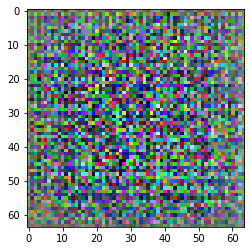

In [30]:
fake = netG(torch.randn(64, nz, 1, 1).to(device))
plt.imshow(normalizeRGB(fake[0].detach().cpu()).permute(1,2,0));
# plt.imshow(normalizeRGB(fakeJNB[i]).permute(1,2,0));

# 6. Training with cadastral images

## 6.1 Training with cadastral images RGB

In [208]:
device

device(type='cuda', index=0)

In [ ]:
%%time
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

netDCadastral = OptDis(ngpu, 3).to(device)
netGCadastral = OptGen(ngpu=ngpu, num_conv_layers=4, drop_conv2=0.4).to(device)

netDCadastral.apply(weights_init)
netGCadastral.apply(weights_init)

optimizerDCadastral = optim.Adam(netDCadastral.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerGCadastral = optim.Adam(netGCadastral.parameters(), lr=lr, betas=(beta1, 0.999))

img_list = trainModel(netGCadastral, netDCadastral, device, Cad_dataloader, optimizerGCadastral, optimizerDCadastral, 
                      epochs=500, nz=nz, fixed_noise=fixed_noise, folder='../', experiment = 'WGANRGB'
                      logger = logger )

Epoch: 0/500 | D Learn: True | D Loss: -10.9832| ErrDReal: 0.9594 | ErrDFake: -12.1157 | GradPenality: 0.1731 | G Loss: 14.5267
Epoch: 10/500 | D Learn: True | D Loss: -145.7593| ErrDReal: -44.5266 | ErrDFake: -101.3511 | GradPenality: 0.1184 | G Loss: 115.5007
Epoch: 20/500 | D Learn: True | D Loss: -273.1745| ErrDReal: -50.0663 | ErrDFake: -223.1714 | GradPenality: 0.0633 | G Loss: 227.6507
Epoch: 30/500 | D Learn: True | D Loss: -479.0895| ErrDReal: -127.109 | ErrDFake: -352.0446 | GradPenality: 0.0642 | G Loss: 357.7718
Epoch: 40/500 | D Learn: True | D Loss: -684.6455| ErrDReal: -160.2955 | ErrDFake: -524.4194 | GradPenality: 0.0694 | G Loss: 526.4803
Epoch: 50/500 | D Learn: True | D Loss: -1005.5472| ErrDReal: -315.791 | ErrDFake: -689.9783 | GradPenality: 0.2221 | G Loss: 691.3519
Epoch: 60/500 | D Learn: True | D Loss: -1291.6217| ErrDReal: -424.3424 | ErrDFake: -867.7017 | GradPenality: 0.4223 | G Loss: 868.5475
Epoch: 70/500 | D Learn: True | D Loss: -1370.0164| ErrDReal: -4

In [29]:
%%time
run_tag = datetime.datetime.now().strftime("%Y-%m-%dT%H:%M:%S")

experiment_id = mlflow.create_experiment(
    f"../reports/TSGAN_Exp_{run_tag}",
    tags={"version": "v1", "priority": "P1"},
)

mlflow.set_experiment(experiment_id=experiment_id)
study = optuna.create_study(study_name=f"WGAN_study_{run_tag}", direction="minimize")

# Wrap the objective inside a lambda and call objective inside it
func = lambda trial: objective(trial, nz, Cad_dataloader, n_epochs = 10, folder = '../',
                              experiment='WGAN_CadastralRGB_')

study.optimize(func, n_trials=1)

[I 2023-06-08 17:47:30,581] A new study created in memory with name: WGAN_study_2023-06-08T17:47:30


Convolutions for D: 4 | Convolutions for G: 4 | LrRate: 0.0001 | Dropout G: 0.2
Epoch: 0/10 | D Loss: -0.6631| ErrDReal: -0.1961 | ErrDFake: -0.6605 | GradPenality: 0.1935 | G Loss: 0.8664
Epoch: 1/10 | D Loss: -2.0409| ErrDReal: -0.715 | ErrDFake: -1.5185 | GradPenality: 0.1926 | G Loss: 1.8661
Epoch: 2/10 | D Loss: -1.7945| ErrDReal: -1.1195 | ErrDFake: -0.8657 | GradPenality: 0.1907 | G Loss: 0.9806
Epoch: 3/10 | D Loss: -0.2535| ErrDReal: -1.7072 | ErrDFake: 1.2637 | GradPenality: 0.19 | G Loss: -0.9694
Epoch: 4/10 | D Loss: -0.2532| ErrDReal: -2.1472 | ErrDFake: 1.7033 | GradPenality: 0.1907 | G Loss: -1.2371
Epoch: 5/10 | D Loss: -1.5527| ErrDReal: -2.3175 | ErrDFake: 0.574 | GradPenality: 0.1907 | G Loss: -0.1383
Epoch: 6/10 | D Loss: -3.1206| ErrDReal: -2.7265 | ErrDFake: -0.5839 | GradPenality: 0.1898 | G Loss: 0.9874
Epoch: 7/10 | D Loss: -2.7547| ErrDReal: -3.1289 | ErrDFake: 0.1855 | GradPenality: 0.1886 | G Loss: 0.0588
Epoch: 8/10 | D Loss: -2.9785| ErrDReal: -3.644 | Err

[I 2023-06-08 17:48:49,173] Trial 0 finished with value: 0.7146042585372925 and parameters: {'lr': 0.00011771245277828545, 'dropoutG': 0.2, 'convsG': 4, 'convsD': 4}. Best is trial 0 with value: 0.7146042585372925.


mse_errG: 0.7146042585372925
CPU times: user 2.87 s, sys: 1.32 s, total: 4.19 s
Wall time: 1min 18s


## 6.2 Training with greyscale cadastral images
the output layer of GNet and the dataset are different from the RGB images 

In [11]:
# logging
loggerGreyscale = logging.getLogger('loggerGreyscale')
loggerGreyscale.setLevel(logging.DEBUG)
# formatter = loggerGreyscale.Formatter("%(asctime)s:%(levelname)s:%(message)s")
file_handler = logging.FileHandler('../reports/WGAN_CadastralGreyscale128_Optimisation.log')
file_handler.setFormatter(formatter)
loggerGreyscale.addHandler(file_handler)

In [12]:
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
  model = nn.DataParallel(model)

In [13]:
%%time

netDCadastrfigsizegreyscale = OptDis128(ngpu=ngpu, num_conv_layers=3).to(device)
netGCadastralGreyscale = OptGenGreyscale128(ngpu=ngpu, num_conv_layers=4, drop_conv2=0.2)

# If more devices are available
if torch.cuda.device_count() > 1:
    netGCadastralGreyscale = nn.DataParallel(netGCadastralGreyscale)
    netDCadastralGreyscale = nn.DataParallel(netDCadastrfigsize=eyscale)

netGCadastralGreyscale.to(device)
netDCadastralGreyscale.to(device)

netDCadastralGreyscale.apply(weights_init)
netGCadastralGreyscale.apply(weights_init)

optimizerDCadastralGreyscale = optim.Adam(netDCadastralGreyscale.parameters(), lr=lr, betas=(beta1, 0.999)) # lr can be a param
optimizerGCadastralGreyscale = optim.Adam(netGCadastralGreyscale.parameters(), lr=lr, betas=(beta1, 0.999)) # lr can be a param

img_list_greyscale = trainModel(netGCadastralGreyscale, netDCadastralGreyscale, device, Cad_dataloader_greyscale, 
                                optimizerGCadastralGreyscale, optimizerDCadastralGreyscale, 
                                epochs=2000, nz=nz, fixed_noise=fixed_noise, folder='../', 
                                experiment='Greyscale128', logger=loggerGreyscale)

NameError: name 'netDCadastralGreyscale' is not defined

In [207]:
torch.save(netGCadastralGreyscale, "../models/WGAN_CadastralGreyscale_Generator")
torch.save(netDCadastralGreyscale, "../models/WGAN_CadastralGreyscale_Discriminator")

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(normalizeRGB(img_list_greyscale[0]).detach().cpu().permute(1,2,0));

## 6.3 Train 128x128 px images

In [101]:
# logging
loggerGreyscale = logging.getLogger('loggerGreyscale')
loggerGreyscale.setLevel(logging.DEBUG)
# formatter = loggerGreyscale.Formatter("%(asctime)s:%(levelname)s:%(message)s")
file_handler = logging.FileHandler('../reports/WGAN_CadastralGreyscale128.log')
file_handler.setFormatter(formatter)
loggerGreyscale.addHandler(file_handler)

In [103]:
%%time
nz = 2**4*4*4 # noise for one single image
fixed_noise = torch.rand((64*2**4*4*4)).to(device)
torch.manual_seed(23)
np.random.seed(23)

netDCadastralgreyscale128 = OptDis128(ngpu, 3)
netGCadastralGreyscale128 = OptGenGreyscale128(ngpu=ngpu, num_conv_layers=4, drop_conv2=0.3)

# If more devices are available
if torch.cuda.device_count() > 1:
    netGCadastralGreyscale128 = nn.DataParallel(netGCadastralGreyscale128)
    netDCadastralgreyscale128 = nn.DataParallel(netDCadastralgreyscale128)

netGCadastralGreyscale128.to(device)
netDCadastralgreyscale128.to(device)

netDCadastralgreyscale128.apply(weights_init)
netDCadastralgreyscale128.apply(weights_init)

optimizerDCadastralGreyscale128 = optim.Adam(netDCadastralgreyscale128.parameters(), lr=lr, betas=(beta1, 0.999)) # lr can be a param
optimizerGCadastralGreyscale128 = optim.Adam(netGCadastralGreyscale128.parameters(), lr=lr, betas=(beta1, 0.999)) # lr can be a param

img_list_greyscale = trainModel(netGCadastralGreyscale128, netDCadastralgreyscale128, device, Cad_dataloader_greyscale, 
                                optimizerGCadastralGreyscale128, optimizerDCadastralGreyscale128, 
                                epochs=10, nz=nz, fixed_noise=fixed_noise, folder='../', logger=loggerGreyscale)

Epoch: 0/10 | D Learn: True | D Loss: -163.3454| ErrDReal: -89.2616 | ErrDFake: -74.2462 | GradPenality: 0.1624 | G Loss: 115.7362
CPU times: user 34 s, sys: 1.72 s, total: 35.8 s
Wall time: 6min 55s


In [58]:
fixed_noise.size()[0]/64

256.0

In [70]:
xf = netGCadastralGreyscale128.forward(fixed_noise)
xf.size()

torch.Size([64, 128, 128, 128])

In [32]:
xr = next(iter(Cad_dataloader_greyscale))[0]
xr.size()

torch.Size([64, 3, 128, 128])

In [61]:
fixed_noise.size()[0]/64/4/4

16.0

In [43]:
print(netGCadastralGreyscale128)

OptGenGreyscale128(
  (main): Sequential(
    (0): ConvTranspose2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): TransConv_2): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(3, 3), bias=False)
    (4): DropOut_2): Dropout2d(p=0.3, inplace=False)
    (5): BatchNorm_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU_2): ReLU(inplace=True)
    (7): TransConv_3): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1), bias=False)
    (8): DropOut_3): Dropout2d(p=0.3, inplace=False)
    (9): BatchNorm_3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU_3): ReLU(inplace=True)
    (11): TransConv_4): ConvTranspose2d(64, 3, kernel_size=(7, 7), stride=(3, 3), padding=(1, 1), bias=False)
    (12): Tanh()
  )
)


In [62]:
x = fixed_noise.view(-1, 2**9, 4, 4)
x = netGCadastralGreyscale128.main[0](x)
print(x.size())

torch.Size([2, 512, 4, 4])


In [39]:
netGCadastralGreyscale128.num_filters

[256, 128, 64, 3, 512]

In [63]:
num_filters = [3] 
num_filters.extend([2**(i+7) for i in range(4-1)])
num_filters

[3, 128, 256, 512]

In [64]:
num_filters.append(2**4)

In [66]:
num_filters.reverse()

In [67]:
num_filters

[16, 512, 256, 128, 3]

# 7. Evaluation Metrics

### 7.1 Frechet Inception Distance
FID calculates the distance between feature vectors calculated for real and generated images, introduced in GANS with the paper by Martin Heusel in 2017 with the paper *GANs Trained by a Two Time-Scale Update Rule Converge to a Local Nash Equilibrium* - https://arxiv.org/abs/1706.08500017

In [8]:
# pip install pytorch-ignite
ignite.utils.manual_seed(999)

In [9]:
ignite.utils.setup_logger(name="ignite.distributed.auto.auto_dataloader", level=logging.WARNING)
ignite.utils.setup_logger(name="ignite.distributed.launcher.Parallel", level=logging.WARNING)

<Logger ignite.distributed.launcher.Parallel (WARNING)>

In [10]:
netG = torch.load("../models/WGAN_CadastralGreyscale_Generator")
netD = torch.load("../models/WGAN_CadastralGreyscale_Discriminator")

In [19]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [20]:
fid_metric = FID(device=device)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /home/furio/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|████████████████████████████████████████████████████████████████████████████████████████| 104M/104M [00:01<00:00, 68.4MB/s]


In [25]:
is_metric = InceptionScore(device=idist.device(), output_transform=lambda x: x[0])

Images need to be interpolated to be evaluated. For this scope an interpolator is used

In [26]:
import PIL.Image as Image

def interpolate(batch):
    arr = []
    for img in batch:
        pil_img = transforms.ToPILImage()(img)
        resized_img = pil_img.resize((299,299), Image.BILINEAR)
        arr.append(transforms.ToTensor()(resized_img))
    return torch.stack(arr)


def evaluation_step(engine, batch):
    with torch.no_grad():
        noise = torch.randn(batch_size, latent_dim, 1, 1, device=idist.device())
        netG.eval()
        fake_batch = netG(noise)
        fake = interpolate(fake_batch)
        real = interpolate(batch[0])
        return fake, real

In [27]:
evaluator = Engine(evaluation_step)
fid_metric.attach(evaluator, "fid")
is_metric.attach(evaluator, "is")

NameError: name 'Engine' is not defined

In [ ]:
def log_training_results(engine):
    evaluator.run(test_dataloader,max_epochs=1)
    metrics = evaluator.state.metrics
    fid_score = metrics['fid']
    is_score = metrics['is']
    fid_values.append(fid_score)
    is_values.append(is_score)
    print(f"Epoch [{engine.state.epoch}/5] Metric Scores")
    print(f"*   FID : {fid_score:4f}")
    print(f"*    IS : {is_score:4f}")

In [ ]:
def get_activations(images, res, batch_size):
    """
    Calculates activations for last pool layer for all iamges
    --
        Images: torch.array shape: (N, 3, res, res), dtype: torch.float32
        batch size: batch size used for inception network
    --
    Returns: np array shape: (N, 2048), dtype: np.float32
    """
    assert images.shape[1:] == (3, res, res), f"Expected input shape to be: (N,3,{res},{res})" +\
                                              f", but got {images.shape}"

    num_images = images.shape[0]
    inception_network = PartialInceptionNetwork()
    inception_network = to_cuda(inception_network)
    inception_network.eval()
    n_batches = int(np.ceil(num_images  / batch_size))
    inception_activations = np.zeros((num_images, 2048), dtype=np.float32)
    for batch_idx in range(n_batches):
        start_idx = batch_size * batch_idx
        end_idx = batch_size * (batch_idx + 1)

        ims = images[start_idx:end_idx]
        ims = to_cuda(ims)
        activations = inception_network(ims)
        activations = activations.detach().cpu().numpy()
        assert activations.shape == (ims.shape[0], 2048), "Expexted output shape to be: {}, but was: {}".format((ims.shape[0], 2048), activations.shape)
        inception_activations[start_idx:end_idx, :] = activations
    return inception_activations

In [ ]:
def FID_calculate_activation_statistics(images, batch_size):
    """Calculates the statistics used by FID
    Args:
        images: torch.tensor, shape: (N, 3, H, W), dtype: torch.float32 in range 0 - 1
        batch_size: batch size to use to calculate inception scores
    Returns:
        mu:     mean over all activations from the last pool layer of the inception model
        sigma:  covariance matrix over all activations from the last pool layer 
                of the inception model.

    """
    act = get_activations(images, batch_size)
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma